In [1]:
from __future__ import print_function 
import os 
from textwrap import wrap
import locale
import pandas as pd 
import numpy as np 

%matplotlib inline 
from matplotlib import pyplot as plt 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
import matplotlib.dates as mdates

from pandas.plotting import autocorrelation_plot

from statsmodels.tsa import stattools

locale.setlocale(locale.LC_ALL, '')

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [51]:
# 
# Some common functions.
# 
def remove_tick_lines(which, ax):
    if which == 'y':
        for line in ax.yaxis.get_majorticklines():
            line.set_visible(False)
    elif which == 'x':
        for line in ax.xaxis.get_majorticklines():
            line.set_visible(False)
    else:
        assert False, "Wrong axis parameter."

def every_nth_tick(ax, every_nth = 2):
    for n, label in enumerate(ax.xaxis.get_ticklabels()):
        if n % every_nth != 0:
            label.set_visible(False)

def autolabel(rects, ax, dec_no=0):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + (height * 0.01),
                '%s' % round(height, dec_no),
                ha='center', va='bottom')

def set_axes_common_properties(axe, no_grid=False):
    rv = 1
    try:
        axe.spines['top'].set_visible(False)
        axe.spines['left'].set_visible(False)
        axe.spines['right'].set_visible(False)
        axe.spines['bottom'].set_visible(False)
        if no_grid == False:
            axe.grid(color='#636262', linestyle='-.', linewidth=0.2)
        rv = 0
    except Exception as ex:
        print("Errore - {e}".format(e=str(ex)))
        
    return rv

# 
global_statistics = {
     "duration": None
    ,"max threads": None
}
dec_num = 2
ok_codes = [200, 202]

# Titles and labels.
it = {
     "thread title": ("Numero thread", 14)
    ,"thread x":     ("Tempo", 12)
    ,"thread y":     ("Numero", 12)
    
    ,"elapsed title":      ("Tempo di servizio", 14)
    ,"elapsed title - log":("Tempo di servizio - scala logaritmica", 14)
    ,"elapsed x":          ("Tempo", 12)
    ,"elapsed y":          ("Tempo di servizio (ms)", 12)

    ,"elapsed-binned title":      ("Tempo di servizio medio", 14)
    ,"elapsed-binned title - log":("Tempo di servizio medio - scala logaritmica", 14)
    ,"elapsed-binned x":          ("Tempo", 12)
    ,"elapsed-binned y":          ("Tempo di servizio medio (ms)", 12)
    ,"elapsed-binned mean txt":   ("Tempo servizio medio", 12)
    ,"elapsed-binned snum y":     ("Numero campioni", 12)
}
en = {
     "thread title": ("Threads number", 14)
    ,"thread x":     ("Time", 12)
    ,"thread y":     ("Number", 12)

    ,"elapsed title":      ("Service time", 14)
    ,"elapsed title - log":("Service time - logarithmic scale", 12)
    ,"elapsed x":          ("Time", 12)
    ,"elapsed y":          ("Service time (ms)", 12)
    
    ,"elapsed-binned title":      ("Average service time", 14)
    ,"elapsed-binned title - log":("Average service time - logarithmic scale", 12)
    ,"elapsed-binned x":          ("Ttime", 12)
    ,"elapsed-binned y":          ("Average service time (ms)", 12)
    ,"elapsed-binned mean txt":   ("Elapsed mean value", 12)
    ,"elapsed-binned snum y":     ("Sample numerosity", 12)
}
labels = it

In [3]:
images_path = os.path.join("..","images")

data_file_path = "/home/giovanni/code-sky/JMeter/MvtGateway/log"
data_file_name = "MvtC2CGateway-C2C-only_20180516_153201-.jtl"

image_file_prefix = "Test-"

data_file = os.path.join(data_file_path, data_file_name)

In [4]:
dtype_dict = {
}

parse_dates = ["timeStamp"]

columns = ["elapsed", "responseCode", "responseMessage","grpThreads","allThreads"]

df = pd.read_csv(data_file, sep='#', lineterminator='\n'
                ,low_memory=False
                ,dtype=dtype_dict)
df["timeStamp"] = pd.to_datetime(df["timeStamp"], unit='ms')
df.set_index("timeStamp", inplace=True)
df.sort_index(axis=0, ascending=True, inplace=True)
#df.sort_values(by=["timeStamp"], inplace=True)

# Get just the columns we need.
df = df[columns]

# Collection of all the sample in error.
errors_df = df.loc[~ df['responseCode'].isin(ok_codes)]

#(df_red.shape, df_red.dtypes)
df.head(2)

,elapsed,responseCode,responseMessage,grpThreads,allThreads
timeStamp,,,,,
2018-05-16 15:32:03.967,125,200,OK,1,1
2018-05-16 15:32:04.100,22,200,OK,1,1


In [54]:
# Calculate the test duration in minutes.
global_statistics["test begin"] = df.index.min()
global_statistics["test end"] = df.index.max()
duration = global_statistics["test end"] - global_statistics["test begin"]

global_statistics["duration"] = round(duration.total_seconds() / 60, dec_num)

# Max number of threads.
global_statistics["max threads"] = df["allThreads"].max()

# Sample len.
global_statistics["sample num"] = df.shape[0]
global_statistics["samples in error"] = errors_df.shape[0]

# Service time statistics.
global_statistics["max elapsed"] = df["elapsed"].max()
global_statistics["min elapsed"] = df["elapsed"].min()
global_statistics["mean elapsed"] = round(df["elapsed"].mean(), dec_num)
global_statistics["std error elapsed"] = round(df["elapsed"].sem(), dec_num)
global_statistics["quantiles elapsed"] = df["elapsed"].quantile(np.arange(0, 1, 0.1))

# Total transactions (sample not in error per second).
global_statistics["quantiles elapsed"]

time_limits = [global_statistics["test begin"] - pd.Timedelta(minutes=0.5) 
              ,global_statistics["test end"] + pd.Timedelta(minutes=0.5)]

global_statistics

{'duration': 15.0,
 'max threads': 150,
 'test begin': Timestamp('2018-05-16 15:32:03.967000'),
 'test end': Timestamp('2018-05-16 15:47:03.839000'),
 'sample num': 106622,
 'samples in error': 0,
 'max elapsed': 3359,
 'min elapsed': 12,
 'mean elapsed': 843.23,
 'std error elapsed': 2.15,
 'quantiles elapsed': 0.0      12.0
 0.1      77.0
 0.2     203.0
 0.3     387.0
 0.4     553.0
 0.5     683.0
 0.6     803.0
 0.7    1016.0
 0.8    1366.0
 0.9    2123.0
 Name: elapsed, dtype: float64}

In [6]:
df['responseCode'].value_counts().loc[200]
#~
df.loc[~ df['responseCode'].isin(ok_codes)].shape[0]


0

In [7]:
#
#
#

def threads_chart(ax, x, y, color):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
    
        ax.step(x, y, color=color)
        ax.set_xlim(time_limits)
    
        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        #seconds = mdates.SecondLocator(bysecond = 30)
        #seconds_fmt = mdates.DateFormatter('%S')
 
        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)

        #ax.xaxis.set_minor_locator(seconds)
        #ax.xaxis.set_minor_formatter(seconds_fmt)
        
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        ax.set_title(labels['thread title'][0], fontsize=labels['thread title'][1])
        ax.set_ylabel(labels["thread y"][0],    fontsize=labels['thread y'][1])
        ax.set_xlabel(labels["thread x"][0],    fontsize=labels['thread x'][1])

    except Exception as ex:
        print("threads_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


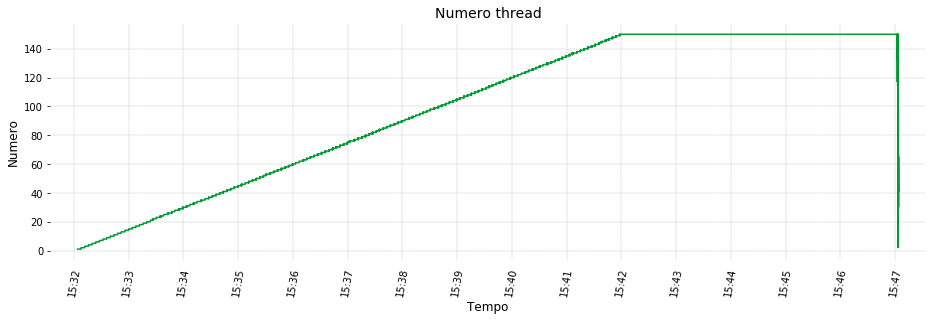

In [8]:
fig = plt.figure(figsize=(50, 8))
gs = fig.add_gridspec(2, 4)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

threads_chart(ax[0], df.index, df["allThreads"], color="#009933")

plt.savefig(os.path.join(images_path,"{prefix}threads_chart.png".format(prefix=image_file_prefix)))



In [35]:
#
#
#

def elapsed_chart(ax, x, y, errors=[None, None], colors=["#0000e6", "#ff1a1a"], logarithmic=False):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
        ax.set_xlim(time_limits)

        ax.scatter(x, y, color=colors[0], s=3)
        if errors is not None and errors[0].shape[0] > 0 and errors[0].shape[0] == errors[1].shape[0]:
            ax.scatter(errors[0], errors[1], color=colors[1], s=3)
    
        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)
       
        ax.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax)
        
        if logarithmic:
            ax.set_yscale('log')
            ax.set_title(labels['elapsed title - log'][0], fontsize=labels['elapsed title - log'][1])
        else:
            ax.set_title(labels['elapsed title'][0], fontsize=labels['elapsed title'][1])
        
        ax.set_ylabel(labels["elapsed y"][0],    fontsize=labels['elapsed y'][1])
        ax.set_xlabel(labels["elapsed x"][0],    fontsize=labels['elapsed x'][1])
            
    except Exception as ex:
        print("elapsed_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


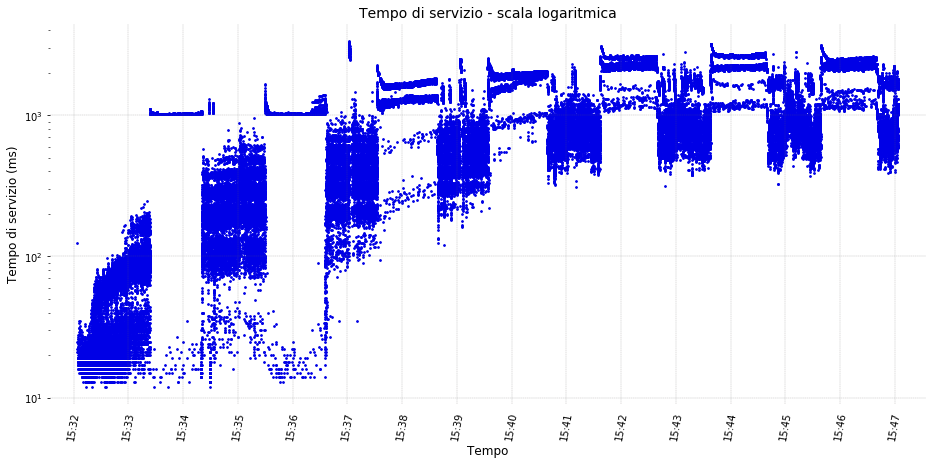

In [36]:
fig = plt.figure(figsize=(50, 12))
gs = fig.add_gridspec(2, 4)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

elapsed_chart(ax[0]
             ,x=df.index, y=df["elapsed"]
             ,errors=[errors_df.index, errors_df["elapsed"]]
             ,logarithmic=True)

plt.savefig(os.path.join(images_path,"{prefix}elapsed_chart.png".format(prefix=image_file_prefix)))


In [84]:
#
#
#

def elapsed_binned_chart(ax, x, y, x_snum, y_snum, colors=["#0000e6", "#d5d5d5", "#c87607"]):
    """
    """
    rv = False
    try:
        set_axes_common_properties(ax, False)
        ax.set_xlim(time_limits)

        ax.step(x, y, color=colors[0])
        ax.hlines(y=global_statistics["mean elapsed"]
                 ,xmin=time_limits[0], xmax=time_limits[1]
                 ,linewidth=2
                 ,color=colors[2])
        
        text_x_position = time_limits[1] + (time_limits[1] - time_limits[0])/2
        ax.text(x=time_limits[0]
               ,y=global_statistics["mean elapsed"] + 50
               ,s=labels["elapsed-binned mean txt"][0]
               ,color=colors[2]
               ,fontsize=labels["elapsed-binned mean txt"][1])

        minutes = mdates.MinuteLocator(interval = 1)
        minutes_fmt = mdates.DateFormatter('%H:%M')

        ax.xaxis.set_major_locator(minutes)
        ax.xaxis.set_major_formatter(minutes_fmt)
       
        ax.tick_params(axis='x', labelrotation=80)

        ax.set_title(labels['elapsed-binned title'][0], fontsize=labels['elapsed-binned title'][1])
        
        ax.set_ylabel(labels["elapsed-binned y"][0], fontsize=labels['elapsed-binned y'][1])
        ax.set_xlabel(labels["elapsed-binned x"][0], fontsize=labels['elapsed-binned x'][1])
        remove_tick_lines('x', ax)
        
        # Second y axis.
        ax_snum = ax.twinx()
        set_axes_common_properties(ax_snum, True)
        
        ax_snum.scatter(x_snum, y_snum, color=colors[1], s=50, alpha=0.9)
        
        ax_snum.set_ylabel(labels["elapsed-binned snum y"][0], fontsize=labels['elapsed-binned snum y'][1])

        ax_snum.xaxis.set_major_locator(minutes)
        ax_snum.xaxis.set_major_formatter(minutes_fmt)     
        ax_snum.tick_params(axis='x', labelrotation=80)
        remove_tick_lines('x', ax_snum)
        remove_tick_lines('y', ax_snum)
        
    except Exception as ex:
        print("elapsed_binned_chart failed - {ex}".format(ex=ex))
    else:
        rv = True    
    return rv


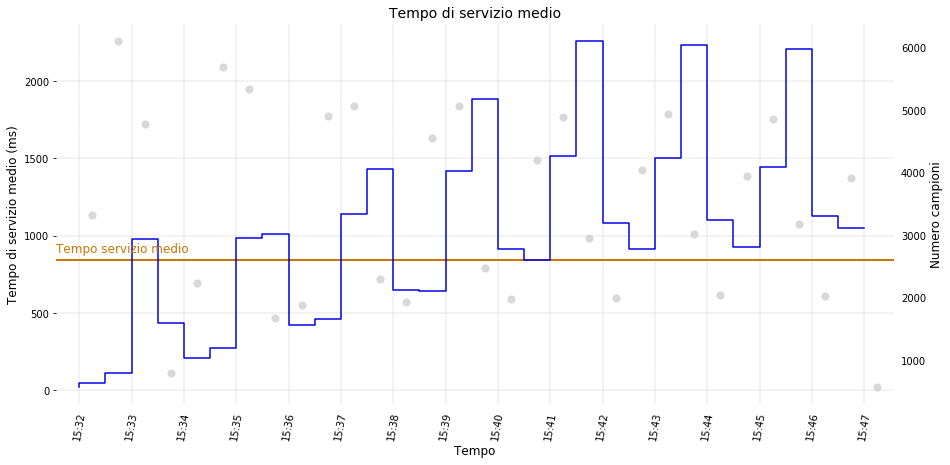

In [85]:
seconds = '30S' 
minutes = 'T'

binned_elapsed = df.groupby(pd.Grouper(level='timeStamp', freq=seconds))['elapsed'].agg(['mean','count']) 
binned_elapsed["dt centered"] = binned_elapsed.index  + pd.offsets.Second(15)

# -----------------------------------------------------------
fig = plt.figure(figsize=(50, 12))
gs = fig.add_gridspec(2, 4)
fig.set_tight_layout(True)

ax = []
ax.append(fig.add_subplot(gs[0, 0]))

elapsed_binned_chart(ax[0]
                    ,x=binned_elapsed.index
                    ,y=binned_elapsed['mean']
                    ,x_snum=binned_elapsed["dt centered"]
                    ,y_snum=binned_elapsed['count'])

plt.savefig(os.path.join(images_path,"{prefix}elapsed_binned_chart.png".format(prefix=image_file_prefix)))


In [72]:
binned_elapsed.index

DatetimeIndex(['2018-05-16 15:32:00', '2018-05-16 15:32:30',
               '2018-05-16 15:33:00', '2018-05-16 15:33:30',
               '2018-05-16 15:34:00', '2018-05-16 15:34:30',
               '2018-05-16 15:35:00', '2018-05-16 15:35:30',
               '2018-05-16 15:36:00', '2018-05-16 15:36:30',
               '2018-05-16 15:37:00', '2018-05-16 15:37:30',
               '2018-05-16 15:38:00', '2018-05-16 15:38:30',
               '2018-05-16 15:39:00', '2018-05-16 15:39:30',
               '2018-05-16 15:40:00', '2018-05-16 15:40:30',
               '2018-05-16 15:41:00', '2018-05-16 15:41:30',
               '2018-05-16 15:42:00', '2018-05-16 15:42:30',
               '2018-05-16 15:43:00', '2018-05-16 15:43:30',
               '2018-05-16 15:44:00', '2018-05-16 15:44:30',
               '2018-05-16 15:45:00', '2018-05-16 15:45:30',
               '2018-05-16 15:46:00', '2018-05-16 15:46:30',
               '2018-05-16 15:47:00'],
              dtype='datetime64[ns]', name='ti

In [71]:
binned_elapsed.index  + pd.offsets.Second(30)

DatetimeIndex(['2018-05-16 15:32:30', '2018-05-16 15:33:00',
               '2018-05-16 15:33:30', '2018-05-16 15:34:00',
               '2018-05-16 15:34:30', '2018-05-16 15:35:00',
               '2018-05-16 15:35:30', '2018-05-16 15:36:00',
               '2018-05-16 15:36:30', '2018-05-16 15:37:00',
               '2018-05-16 15:37:30', '2018-05-16 15:38:00',
               '2018-05-16 15:38:30', '2018-05-16 15:39:00',
               '2018-05-16 15:39:30', '2018-05-16 15:40:00',
               '2018-05-16 15:40:30', '2018-05-16 15:41:00',
               '2018-05-16 15:41:30', '2018-05-16 15:42:00',
               '2018-05-16 15:42:30', '2018-05-16 15:43:00',
               '2018-05-16 15:43:30', '2018-05-16 15:44:00',
               '2018-05-16 15:44:30', '2018-05-16 15:45:00',
               '2018-05-16 15:45:30', '2018-05-16 15:46:00',
               '2018-05-16 15:46:30', '2018-05-16 15:47:00',
               '2018-05-16 15:47:30'],
              dtype='datetime64[ns]', name='ti